# Choral Synthesizer

For disquiet 0419 we were given lots of samples at lots of frequencies with lots of overtones and
lots of qualities. I would like to be able to synthesize a sort of haunting tone at a roughly constant
frequency in a stero signal given those. So pull all the samples apart with librosa and build something
which is kind of a long grain granular synth / mixer / retuner.

In [122]:
import math
import numpy as np
import librosa
import os
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import random
import scipy.signal.windows
import IPython.display as ipd

sr = 48000

In [123]:
def loadAllFiles():
    res = {}
    for fn in os.listdir( "samples/" ):
        (res[ fn ],_unusedsr) = librosa.load("samples/" + fn, sr=sr, mono=True)
        if( fn.startswith( "ejkelly" ) ):
            res[fn] = res[fn] * 8
    return res

allFileData = loadAllFiles()

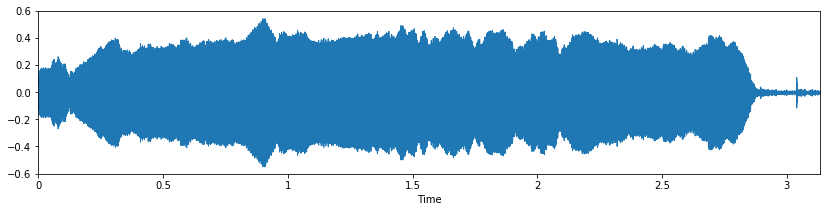

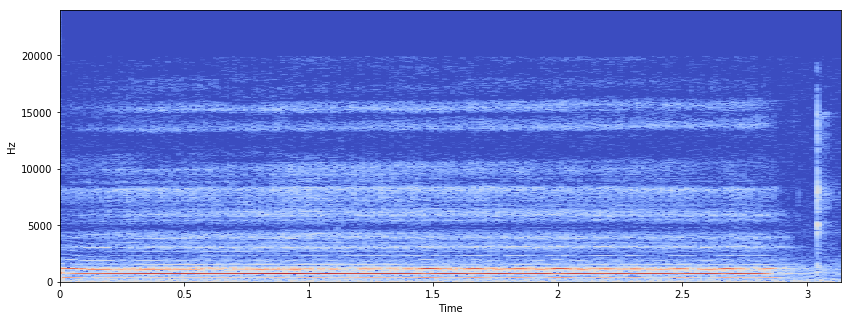

In [124]:
def showFile( fn ):
    fd = allFileData[fn]
    plt.figure( figsize=(14,3))
    librosa.display.waveplot(fd,sr=sr)
    X = librosa.stft(fd)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

showFile( 'ejkelly-g4-aah.wav')

In [125]:
fd = allFileData['ejkelly-g4-aah.wav']
pitches, magnitudes = librosa.core.piptrack(fd, sr=sr, fmin=75, fmax=2000, n_fft=2048)
[np.shape(pitches), np.shape(fd), np.shape(fd)[0] / np.shape(pitches)[1]]

[(1025, 294), (150416,), 511.6190476190476]

In [126]:
fd = allFileData['baconpaul-daughter-g-ahh.wav']
pitches, magnitudes = librosa.core.piptrack(fd, sr=sr, fmin=75, fmax=2000)
[np.shape(pitches), np.shape(fd), np.shape(fd)[0] / np.shape(pitches)[1]]

[(1025, 385), (196608,), 510.67012987012987]

OK great, so clearly the piptrack gives us the frequency spectrum in 512 block length intervals. That's really useful. At our sample rate how many blocks give us a tenth of a second? The answer is "about 10 blocks"

In [127]:
time = 512/sr
blocks = 0.1 / time
[time, blocks]

[0.010666666666666666, 9.375]

What's in that pitches array and magnitude array? Take a single slice

In [128]:
fd = allFileData['baconpaul-daughter-g-ahh.wav']
pitches, magnitudes = librosa.core.piptrack(fd, sr=sr, fmin=40, fmax=5000)

p120 = pitches[:,120]
m120 = magnitudes[:,120]

i0 = -1
for i in range(len(m120)):
    if( m120[i] > 5):
        if( i0 < 0 ):
            i0 = i
        print( p120[i], " " , m120[i], " ", p120[i] / p120[i0])

395.56644   26.871807   1.0
790.71655   28.013731   1.9989475
1183.9298   19.080135   2.9929986
1577.828   10.021453   3.9887812


And hey would you look at that, theres the fundamental and first four harmonics from that sample. Great.

And so now we can introduce

## A plan of attack

The dataset I want is all 10-block streaks where the fundamental is roughly the same, along with the fundamental. If I have that, I can use that streak to join together a tone at that fundamental. I can also do some alias-y time stretching and shrinking to adjust pitch. 

In [129]:
pitchAndMagnitudeData = {}
for k in allFileData.keys():
    pitchAndMagnitudeData[k] = librosa.core.piptrack(allFileData[k], sr=sr, fmin=40, fmax=5000)

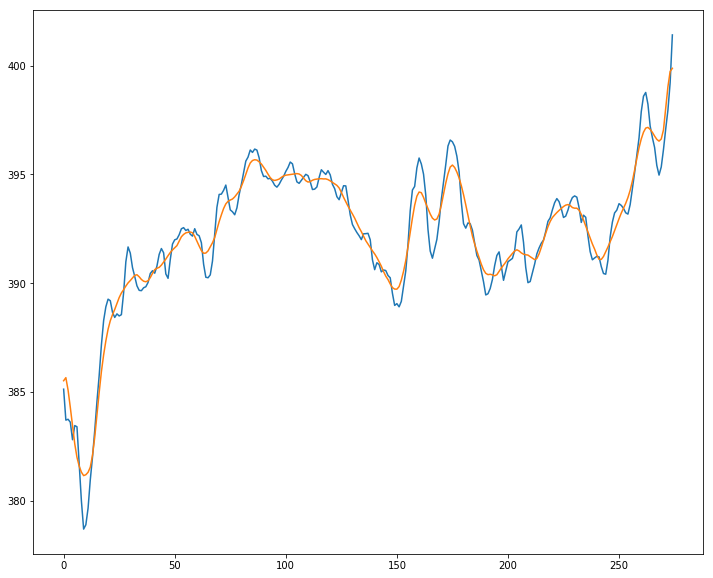

In [130]:
def fundaments(fn):
    (p,m) = pitchAndMagnitudeData[fn]
    shape = np.shape(p)
    nObs = shape[1]
    fundamental = np.zeros( nObs )
    for i in range( nObs ):
        thisp = p[:,i]
        thism = m[:,i]
        found = False
        for j in range( len( thisp ) ):
            if( thism[j] > 5 and not found ):
                fundamental[i] = thisp[j]
                found = True
            if( found ):
                break
    smoothed =  np.convolve( fundamental, np.ones((10,))/10, mode='same' )
    edges = np.abs(smoothed - fundamental)
    valid = np.logical_and( edges < 5, fundamental > 40 )
    return (fundamental, smoothed, valid )
    
(f,smoothed,valid) = fundaments( 'baconpaul-daughter-g-ahh.wav' )
plt.figure(figsize=(12, 10))
plt.plot( f[valid] )
plt.plot( smoothed[valid] )


So now we have a mechanism to find the approximate frequency of a 10 block chunk. Cool. So lets calculate that curve for everyone.

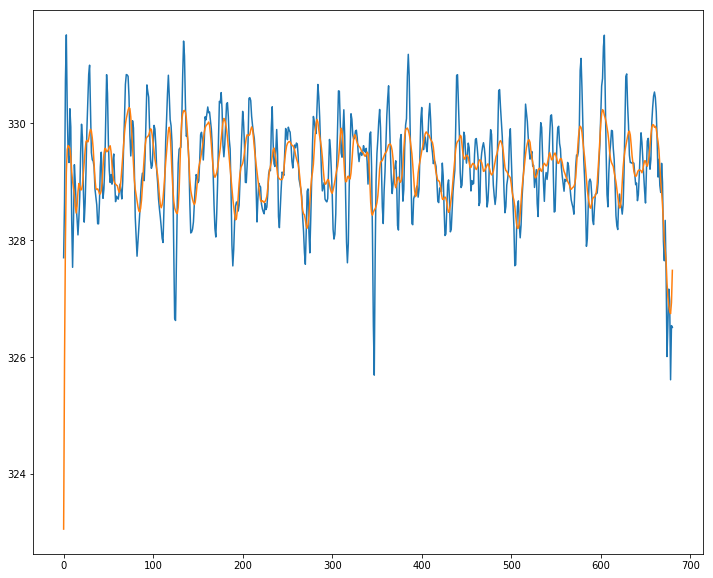

In [131]:
(f,smoothed,valid) = fundaments( 'samarobryn--e.wav' )
plt.figure(figsize=(12, 10))
plt.plot( f[valid] )
plt.plot( smoothed[valid] )


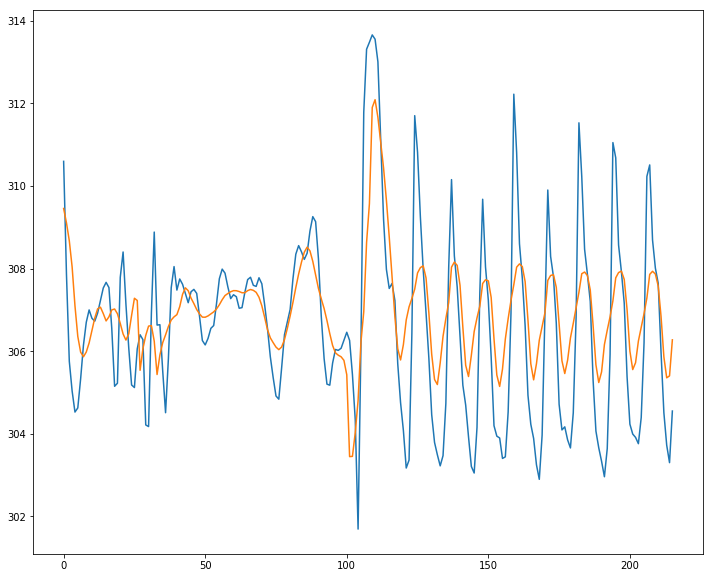

In [132]:
(f,smoothed,valid) = fundaments( 'Patricia Wolf Dischorus Ohhh.wav' )
plt.figure(figsize=(12, 10))
plt.plot( f[valid] )
plt.plot( smoothed[valid] )

In [133]:
fundamentsData = {}
for k in allFileData.keys():
    fundamentsData[k] = fundaments(k)

Alright so now I'm going to see if I can make a middle c (261.63) from this data set in any way. I'll do it by scanning all the fundamentsData lookign for things within +/- 2 of 261.63 and also valid and see how much I get. Then glue together those blocks. For now I'll do it silly and loopwise with no clever vector stuff.

In [151]:
def samplesNearFrequency(target):
    targetHigh = target * 1.03
    targetLow = target * 0.97

    files = []
    samples = {}
    flatsamples = []
    for k in fundamentsData.keys():
        (f,s,v) = fundamentsData[k]
        for i in range( len(f) ):
            if( v[i] and s[i] < targetHigh and s[i] > targetLow ):
                if( not k in samples ):
                    samples[k] = []
                    files.append(k)
            
                samples[k].append(i)
                flatsamples.append( (k,i))
    #if( len( flatsamples ) < 50 ):
    #    print( "Warning: FlatSamples low at frequency ", target, " ", len(flatsamples) )
    #if( len( files ) < 4 ):
    #    print( "Warning: Files low at frequency ", target, " ", len(files) )
        
    return( files, samples, flatsamples )

files,samples,fs = samplesNearFrequency(261.63)
files
        

['eww Vonna Wolf.wav',
 'ejkelly-c4-ooh.wav',
 'Henk-Lasschuit--eu.wav',
 'danieldiaz-e-syllabe-twice.wav',
 'samarobryn--u.wav',
 'samarobryn--o.wav',
 'ejkelly-c4-aah.wav']

In [149]:
def freqForNote(n):
    return pow( 2.0, (n - 60 ) / 12.0 ) * 261.63

used = {}
for i in range( 49 ):
    p = freqForNote( i + 36 )
    f,s,u = samplesNearFrequency(p)
    print( 60-12-12+i, p, " ", len(f), len(u) )
    for e in f:
        used[e] = True
        

36 65.4075   1 2
37 69.29683234430561   6 1213
38 73.41743642479531   7 1486
39 77.78306437454047   5 70
40 82.40828607099891   2 63
41 87.30853776162652   4 416
42 92.50017358091822   8 1374
43 98.00052013081155   17 2399
44 103.82793430661002   18 1683
45 110.00186456141466   24 1722
46 116.54291581352848   21 6507
47 123.47291821345574   17 737
48 130.815   14 664
49 138.59366468861123   17 2451
50 146.83487284959062   21 2433
51 155.56612874908095   13 720
52 164.81657214199782   16 3878
53 174.61707552325305   9 602
54 185.00034716183643   11 1455
55 196.0010402616231   10 2237
56 207.65586861322004   14 476
57 220.00372912282933   23 2524
58 233.08583162705696   18 5831
59 246.94583642691148   3 12
60 261.63   7 1649
61 277.18732937722245   3 1558
62 293.66974569918125   1 2
63 311.1322574981619   3 231
64 329.63314428399565   4 1304
65 349.2341510465061   1 3
66 370.00069432367286   2 9
67 392.0020805232462   6 1377
68 415.31173722644   2 549
69 440.00745824565865   2 418
70 466

In [136]:
for k in allFileData.keys():
    if( not k in used ):
        print( k, "is unused" )

atomboyd--whisper-sigh.wav is unused


In [137]:
(f,s,fl) = samplesNearFrequency(130.815)
len(fl)

664

OK so now lets do some DSP. We need to grab 15 items from random, and overlap them together with a window

In [139]:
block_size=512
nchunks = 10
random.seed(173204)
obs = []
for i in range(30):
    obs.append( fl[ random.randint(0,len(fl)-1) ] )
obs

[('baconpaul-c-mmm.wav', 127),
 ('Henk-Lasschuit--eu.wav', 43),
 ('zoundsabarΓÇömmm 2.wav', 552),
 ('Henk-Lasschuit--eu.wav', 307),
 ('baconpaul-c-mmm.wav', 48),
 ('Henk-Lasschuit--eu.wav', 112),
 ('Yasha-ohhhh.wav', 15),
 ('Henk-Lasschuit--eu.wav', 61),
 ('Henk-Lasschuit--eu.wav', 246),
 ('baconpaul-c-mmm.wav', 70),
 ('broken-hours--drone-syllable.wav', 32),
 ('baconpaul-c-mmm.wav', 174),
 ('baconpaul-c-mmm.wav', 314),
 ('zoundsabarΓÇöahh 1.wav', 400),
 ('baconpaul-c-mmm.wav', 232),
 ('zoundsabarΓÇömmm 2.wav', 553),
 ('Henk-Lasschuit--eu.wav', 58),
 ('baconpaul-c-mmm.wav', 158),
 ('Henk-Lasschuit--eu.wav', 308),
 ('baconpaul-c-mmm.wav', 134),
 ('baconpaul-c-mmm.wav', 191),
 ('baconpaul-c-mmm.wav', 287),
 ('baconpaul-c-mmm.wav', 362),
 ('baconpaul-c-mmm.wav', 341),
 ('Henk-Lasschuit--eu.wav', 295),
 ('baconpaul-c-mmm.wav', 391),
 ('baconpaul-c-mmm.wav', 252),
 ('zoundsabarΓÇöahh 1.wav', 549),
 ('baconpaul-e-zzh.wav', 24),
 ('baconpaul-c-mmm.wav', 234)]

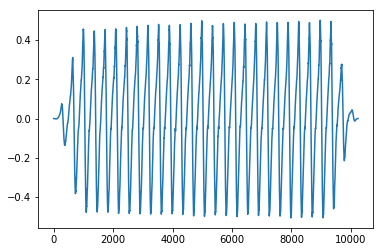

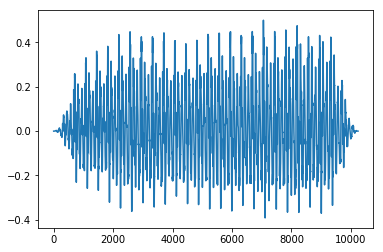

In [140]:
def segmentFromFileNonOver( fn, sp, chunkWindow = 10, windowblocks = 2 ):
    da = allFileData[fn]
    start = (sp-chunkWindow) * block_size
    if( start < 0 ):
        start = 0
    end = ( sp + chunkWindow ) * block_size
    if( end >= len(da)):
        end = len(da)
    seg = da[start:end]

    w = scipy.signal.windows.hann(windowblocks * block_size * 2)
    ws = w[0:windowblocks * block_size]
    we = w[windowblocks * block_size:]
    con = np.ones(len(seg)-len(w))
    r = np.concatenate( [ ws, con, we ] )
    mv = np.max( r * seg )
    
    return ( seg, r * seg / ( mv * 2 ), w)

(fn,sp) = obs[0]
(seg,faded,window) = segmentFromFileNonOver( fn, sp )
plt.plot(faded)
plt.show();
(fn,sp) = obs[1]
(seg,faded,window) = segmentFromFileNonOver( fn, sp )
plt.plot(faded)
plt.show();



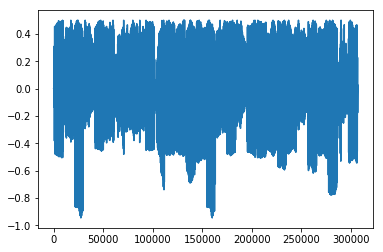

In [141]:
def concatObservations(obs):
    ss = []
    for (f,s) in obs:
        (seg,faded,window) = segmentFromFileNonOver(f,s)
        ss.append(faded)
    res = np.concatenate(ss)
    return res

res = concatObservations(obs)
plt.plot(res)

In [142]:
ipd.Audio(res, rate=sr)

So now we can start expanding this into a couple of other ideas. Cleaner overlaps to remove the beating, and also some vibrato and overarching envelope stuff. So lets start with the cleaner overlaps

In [143]:
sz = 10
a = np.ones(sz)
b = np.ones(sz) + 2
np.concatenate([a,b])

news = sz + 5
newr = np.zeros( news )
newr[0:len(a)] = a
newr[news-len(b):] = newr[news-len(b):] + b
newr

array([1., 1., 1., 1., 1., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3.])

In [144]:
# This is not very efficient but
def concatObservationsOverlap(obs, chunkWindow=10):
    res = []
    overlap = 2 * block_size
    for (f,s) in obs:
        (seg,faded,window) = segmentFromFileNonOver(f,s, chunkWindow=chunkWindow)
        if( len(res) == 0 ):
            res = faded
        else:
            news = len(res) + len(faded) - overlap
            tmp = np.zeros( news)
            tmp[0:len(res)] = res
            tmp[news-len(faded):] = tmp[news-len(faded):] + faded
            res = tmp
    return res

res = concatObservationsOverlap(obs)
ipd.Audio(res, rate=sr)

In [ ]:
plt.plot(res)

In [145]:

random.seed(173206)

def audioForNotes(notes):
    inter = []

    cw = 10
    for n in notes:
        freq = freqForNote(n)
        (f,s,fl) = samplesNearFrequency(freq )
 
        obsC = []
        for i in range( 16 ):
            obsC.append( fl[ random.randint(0,len(fl)-1) ] )
        res = concatObservationsOverlap(obsC, chunkWindow=cw)
        inter.append(res)
    
    ml = 0;
    for iv in inter:
        if(len(iv)>ml):
            ml = len(iv)
    finalR = np.zeros(ml)
    
    for iv in inter:
        finalR[0:len(iv)] = finalR[0:len(iv)] + iv
    return finalR

a1 = audioForNotes( [ 48, 52, 55 ] );
a2 = audioForNotes( [ 48, 53, 57 ] );
a3 = audioForNotes( [ 48, 52, 55, 58 ] );
    
song = np.concatenate([a1,a2,a3]);
ipd.Audio( song, rate=sr )

In [146]:
def nmf(s):
    nv = {'c' : 0, 'd' : 2, 'e' : 4, 'f' : 5, 'g' : 7, 'a' : 9, 'b' : 11 };
    n = nv[s[0]]
    if(len(s)==2):
        o = int(s[1])
        a = 0
    else:
        o = int(s[2])
        a = s[1];
        if( a == '#' ):
            a = 1
        else:
            a = 0
            
    
    # return (n,a,o)
    return n + (o+1)*12 + a

[nmf('c3'), nmf('e3'),nmf('g3'), nmf('a3')]


[48, 52, 55, 57]

In [147]:
wtc = [ ['c4', 'e4', 'g4', 'c5', 'e5' ],
        ['c4', 'd4', 'a4', 'd5', 'f5' ],
        ['b3', 'd4', 'g4', 'd5', 'f5' ],
        ['c4', 'e4', 'g4', 'c5', 'e5' ],
        
        ['c4', 'e4', 'a4', 'e5', 'a5' ],        
        ['c4', 'd4', 'f#4', 'a4', 'd5' ],
        ['b3', 'd4', 'g4', 'd5', 'g5' ],
        ['b3', 'c4', 'e4', 'g4', 'c5' ],
       
        ['a3', 'c4', 'e4', 'g4', 'c5' ],
        ['d3', 'b3', 'd4', 'f#4', 'c5' ],
        ['g3', 'b3', 'd4', 'g4', 'b4' ],
        ['g3', 'a#3', 'e4', 'g4', 'c#5' ],
       
        [ 'g3', 'b3', 'd4', 'a4', 'd5' ],
        [ 'g3', 'a#3', 'd4', 'f4', 'd5' ],
        [ 'e3', 'g3', 'c4', 'g4', 'c5' ],
        [ 'e3', 'f3', 'a3', 'c4', 'f4' ]
      ]

In [148]:
random.seed(173207)
music = []
for w in wtc[0:]:
    r = [ nmf(n) - 12 for n in w ]
    print(r)
    music.append(audioForNotes(r))
song = np.concatenate(music)
ipd.Audio(song, rate=sr)

[48, 52, 55, 60, 64]
[48, 50, 57, 62, 65]
[47, 50, 55, 62, 65]
[48, 52, 55, 60, 64]
[48, 52, 57, 64, 69]
[48, 50, 54, 57, 62]
[47, 50, 55, 62, 67]
[47, 48, 52, 55, 60]
[45, 48, 52, 55, 60]
[38, 47, 50, 54, 60]
[43, 47, 50, 55, 59]
[43, 46, 52, 55, 61]
[43, 47, 50, 57, 62]
[43, 46, 50, 53, 62]
[40, 43, 48, 55, 60]
[40, 41, 45, 48, 53]


Some messed up notes include 65 and others which are prominent. Lets go figure out good fill in strategy

In [ ]:
# samplesNearFrequency(freqForNote(65))
ipd.Audio( audioForNotes( [62 ] ), rate=sr )

In [163]:
good = []
bad = []
med = []
for i in range( 49 ):
    p = freqForNote( i + 36 )
    f,s,u = samplesNearFrequency(p)
    if( len(u) > 100 and len(f) > 10 ):
        good.append( (i + 36, p, len(f), len(u) ) )
    elif( len(u) < 10 ):
        bad.append((i+36,p,len(f),len(u)))
    else:
        med.append((i+36,p,len(f),len(u)))
    
(good, bad, med)

([(43, 98.00052013081155, 17, 2399),
  (44, 103.82793430661002, 18, 1683),
  (45, 110.00186456141466, 24, 1722),
  (46, 116.54291581352848, 21, 6507),
  (47, 123.47291821345574, 17, 737),
  (48, 130.815, 14, 664),
  (49, 138.59366468861123, 17, 2451),
  (50, 146.83487284959062, 21, 2433),
  (51, 155.56612874908095, 13, 720),
  (52, 164.81657214199782, 16, 3878),
  (54, 185.00034716183643, 11, 1455),
  (56, 207.65586861322004, 14, 476),
  (57, 220.00372912282933, 23, 2524),
  (58, 233.08583162705696, 18, 5831)],
 [(36, 65.4075, 1, 2),
  (62, 293.66974569918125, 1, 2),
  (65, 349.2341510465061, 1, 3),
  (66, 370.00069432367286, 2, 9),
  (76, 659.2662885679913, 0, 0),
  (77, 698.4683020930122, 0, 0),
  (78, 740.0013886473457, 1, 3),
  (79, 784.0041610464924, 1, 2),
  (80, 830.6234744528801, 0, 0),
  (81, 880.0149164913173, 0, 0),
  (82, 932.3433265082278, 0, 0),
  (83, 987.7833457076459, 0, 0),
  (84, 1046.52, 0, 0)],
 [(37, 69.29683234430561, 6, 1213),
  (38, 73.41743642479531, 7, 1486),

In [174]:
# OK so lets generate a fillup
def fillup(n, good):
    ops = []
    p0 = freqForNote(n)
    for dis in range(5):
        if( n - 2 + dis != n ):
            p = freqForNote(n-2+dis)
            (f,s,u) = samplesNearFrequency(p)
            for file in f:
                ops.append( ( file, p / p0 ) )
                
    # and add in the A220
    dist = 100000
    tp = 0
    for (ng,p,lu,lf) in good:
        print( dist, ng, n )
        if abs(ng-n) < dist:
            dist = ng-n
            tp = p
    print( tp )
    return ops
fillup(65, good)

100000 43 65
-22 44 65
-22 45 65
-22 46 65
-22 47 65
-22 48 65
-22 49 65
-22 50 65
-22 51 65
-22 52 65
-22 54 65
-22 56 65
-22 57 65
-22 58 65
98.00052013081155


[('ejkelly-e4-aah.wav', 0.8908987181403393),
 ('eelsOS-aaaaah.wav', 0.8908987181403393),
 ('Patricia Wolf Dischorus Ohhh.wav', 0.8908987181403393),
 ('samarobryn--e.wav', 0.9438743126816934),
 ('ejkelly-e4-aah.wav', 0.9438743126816934),
 ('atomboyd--high-ooh.wav', 0.9438743126816934),
 ('kenneth-held-eee.WAV', 0.9438743126816934),
 ('baconpaul-daughter-g-nnnng.wav', 1.0594630943592953),
 ('BellyFullOfStars—oooo-Dischoir.wav', 1.0594630943592953),
 ('baconpaul-daughter-g-ahh.wav', 1.122462048309373),
 ('Henk-Lasschuit--eu.wav', 1.122462048309373),
 ('ejkelly-g4-ooh.wav', 1.122462048309373),
 ('ejkelly-g4-aah.wav', 1.122462048309373),
 ('baconpaul-daughter-g-nnnng.wav', 1.122462048309373),
 ('BellyFullOfStars—oooo-Dischoir.wav', 1.122462048309373)]